In [1]:
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import tensorflow

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2023-03-20 21:07:05.320881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 21:07:05.442029: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-20 21:07:05.445273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 21:07:05.445291: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

df = pd.read_csv("synthetic_encoded_dataset.csv")
df.shape

(79844, 14)

In [3]:
from sklearn.model_selection import train_test_split

y = df.y.to_frame()
X = df.drop(columns = ["y"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
ids = np.arange(0, df.shape[0])
df["ClientID"] = ids
df.head()
df.shape

(79844, 15)

In [5]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = X
    data["y"] = y
    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def build_model(X, y):
    rf = RandomForestClassifier()
    rf.fit(X, y)
    return rf


In [7]:
def test_global_model(X_test, y_test, local_models):
  y_predrf = np.zeros(y_test.shape[0])

  for model in local_models:
    y_predrf_local_model = model.predict(X_test)
    y_predrf = np.add(y_predrf, y_predrf_local_model)

  y_predrf = pd.DataFrame(y_predrf, columns=['y'])

  n = len(local_models)//2 + 1

  y_predrf.loc[(y_predrf.y <n), "y"] = 0
  y_predrf.loc[(y_predrf.y >=n), "y"] = 1
  accrf = accuracy_score(y_test, y_predrf)
  return accrf

  

In [8]:
def create_local_models(c):
  m = []
  c_names = list(c.keys())

  for c_name in c_names:
    df = c[c_name]
    y = df.y.to_frame()
    X = df.drop(columns = ["y"])
    local_model = build_model(X, y)
    m.append(local_model)
  return m

In [9]:
n = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]
acc = []

for i in n:
  clients = create_clients(X_train, y_train, num_clients=i, initial='client')
  models = create_local_models(clients)
  acc_clients = test_global_model(X_test, y_test, models)
  acc.append(acc_clients*100)
n, acc

([3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31],
 [86.26174076393237,
  80.5009392611146,
  76.0926737633062,
  73.52536005009392,
  72.09768315591735,
  71.40889167188479,
  70.5823418910457,
  70.28177833437695,
  68.36568566061365,
  66.08641202254226,
  64.05760801502818,
  62.88040075140889,
  63.00563556668754,
  63.78209142141515,
  63.79461490294302])

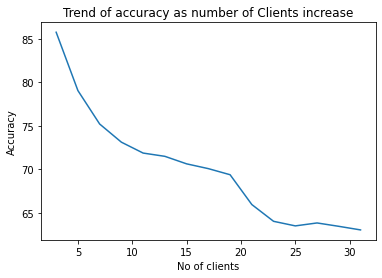

In [10]:
plt.plot(n, acc, linestyle = '-')
plt.xlabel('No of clients')
plt.ylabel('Accuracy')
plt.title('Trend of accuracy as number of Clients increase')
plt.show()

In [11]:
def create_local_models_same(c):
  m = []
  c_names = list(c.keys())
  
  count = 0

  for c_name in c_names:
    if count == 3:
      break
    df = c[c_name]
    y = df.y.to_frame()
    X = df.drop(columns = ["y"])
    data = X.shape[0]
    local_model = build_model(X, y)
    m.append(local_model)
    count = count +1

  return (data, m)

In [12]:
n = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
acc_3 = []
data_size = []

for i in n:
  clients = create_clients(X_train, y_train, num_clients=i, initial='client')
  data, models = create_local_models_same(clients)
  acc_clients = test_global_model(X_test, y_test, models)
  acc_3.append(acc_clients*100)
  data_size.append(data)
acc_3, data_size

([85.84846587351284,
  54.42705072010019,
  50.11897307451471,
  50.03130870381967,
  50.0187852222918,
  50.0187852222918,
  50.00626174076393,
  50.0187852222918,
  50.00626174076393,
  50.0187852222918,
  50.00626174076393,
  50.00626174076393],
 [26614, 15968, 11406, 8871, 7258, 6141, 5322, 4696, 4202, 3802, 3471, 3193])

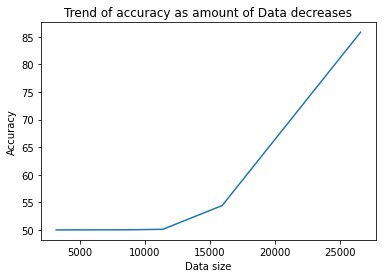

In [14]:
plt.plot(data_size, acc_3)
plt.xlabel('Data size')
plt.ylabel('Accuracy')
plt.title('Trend of accuracy as amount of Data decreases')
plt.show()

In [15]:
# Random forrest with decision tree
from sklearn.tree import DecisionTreeClassifier

In [16]:
def build_decision_tree(X, y):
  clf = DecisionTreeClassifier()
  clf.fit(X, y)
  return clf

In [17]:
def create_local_decision_trees(c):
  m = []
  c_names = list(c.keys())

  for c_name in c_names:
    df = c[c_name]
    y = df.y.to_frame()
    X = df.drop(columns = ["y"])
    local_decision_tree = build_decision_tree(X, y)
    m.append(local_decision_tree)
  return m

In [18]:
n = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]
acc_decision_trees = []

for i in n:
  clients = create_clients(X_train, y_train, num_clients=i, initial='client')
  models = create_local_decision_trees(clients)
  acc_clients = test_global_model(X_test, y_test, models)
  acc_decision_trees.append(acc_clients*100)

n, acc_decision_trees

([3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31],
 [79.62429555416406,
  72.69881026925485,
  69.17971195992486,
  67.82717595491546,
  65.97370068879148,
  64.90920475892298,
  66.19912335629306,
  64.85911083281152,
  63.957420162805256,
  63.231058234189106,
  64.84658735128366,
  64.73387601753288,
  64.42078897933625,
  63.83218534752662,
  63.731997495303695])

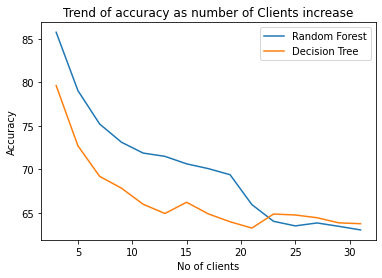

In [19]:
plt.plot(n, acc)
plt.plot(n, acc_decision_trees, linestyle = '-')
plt.xlabel('No of clients')
plt.ylabel('Accuracy')
plt.title('Trend of accuracy as number of Clients increase')
plt.legend(['Random Forest', 'Decision Tree'])
plt.show()